# Translation model from COCO -> MPII


In [92]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from lovely_numpy import lo
import scipy
import json

In [93]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base/IMG-mpii_train-Rep-coco.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth_val_set = json.load(f)

with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base/IMG-mpii_val-Rep-coco.json', 'r') as f:
    annot_pred_coco_val_set = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)


In [94]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
# X_score = X[:,:,-1]
# X = X[:,:,:-1]

y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (22246, 17, 2)
y shape: (22246, 16, 2)
box scale: (22246,)
box center: (22246, 2)


In [95]:
# joint_threshold_mask = X_score > 0.2
# joint_threshold_mask = np.expand_dims(joint_threshold_mask, -1)
# X = X * joint_threshold_mask

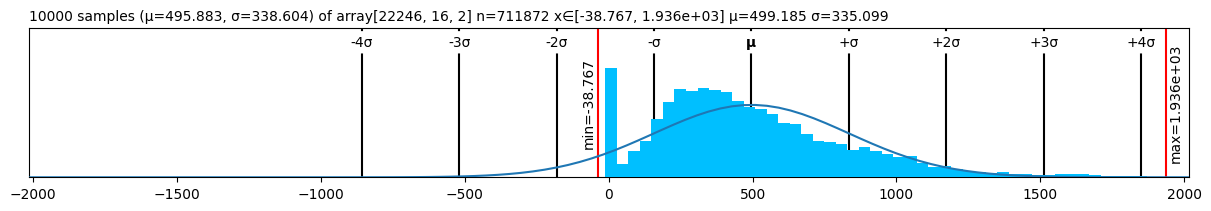

In [96]:
lo(y).plt

How many negative examples are there on each of those (negative doesn't mean anything, except for -1 for 1 where it's non-visible)

In [97]:
print((X < 0).sum())
print(((y < 0) & (y != -1)).sum())
negative_x_mask = np.any(X[:,:,0] <= 0, axis=1) | np.any(X[:,:,1] <= 0, axis=1)

X_clean = X[~negative_x_mask]
y_clean = y[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1)
X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)


425
325
(21768, 17, 2)
(21768, 16, 2)


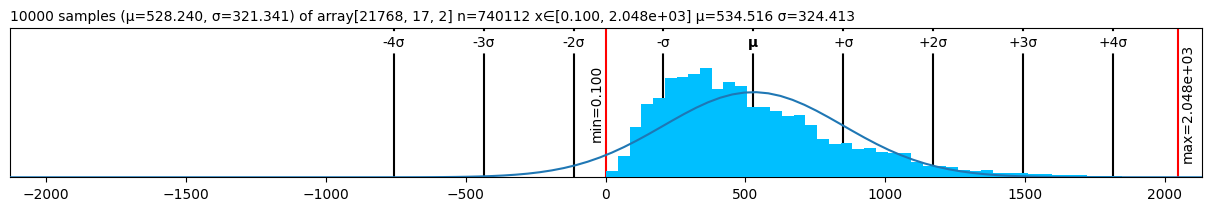

In [98]:
lo(X_clean).plt

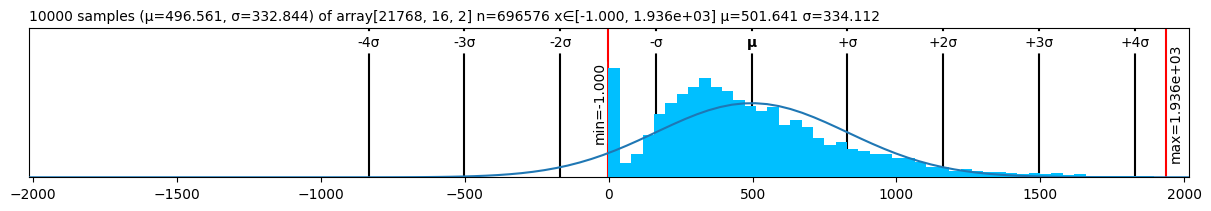

In [99]:
lo(y_clean).plt

## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [100]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2

# needs masking on normalization as well
# to not use not joint visible points
def unnormalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  data = copy.deepcopy(data)

  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data *= bbox_width[:, np.newaxis, :]
  data += bbox_left[:, np.newaxis, :]
  if isinstance(mask, np.ndarray):
    data = data * mask
    # To make back to -1
    data = data + (-1) * (1 - mask)

  return data

def normalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
 
  if isinstance(mask, np.ndarray):
      data = data * mask
      # To make back to -1
      data = data + (-1) * (1 - mask)
  return data
  # bbright point
  # return data
X_normalized = normalize(X_clean, box_center=box_center_clean, box_scale=box_scale_clean)
y_normalized = normalize(y_clean, box_center=box_center_clean, box_scale=box_scale_clean, mask=(y_clean != -1))
lo(y_normalized)

array[21768, 16, 2] n=696576 (5.3Mb) x∈[-1.159, 1.230] μ=0.402 σ=0.397

In [101]:
# Check normalize and unnormalize
print((y == unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))).sum() != 0)
identity = unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))
print((identity - y).sum())


True
-1.646778546859906e-11


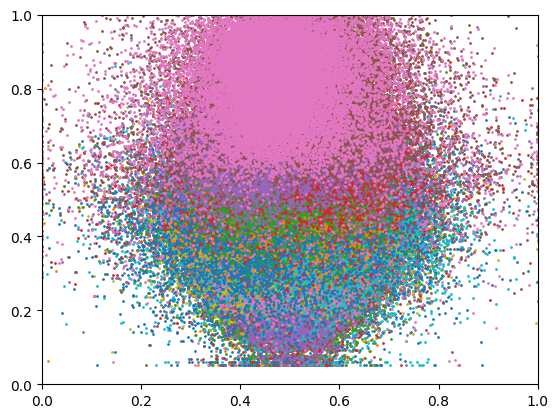

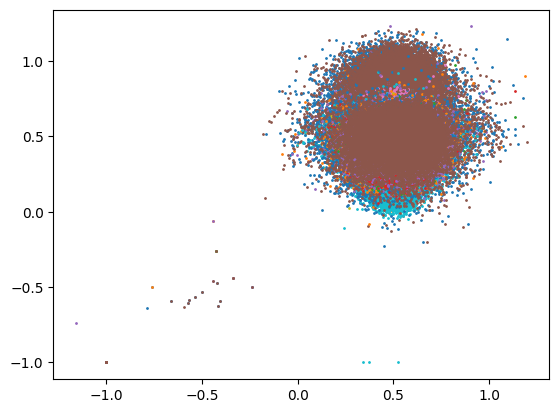

In [102]:
plt.xlim([0,1])
plt.ylim([0,1])

for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Clean normalized

In [103]:
negative_x_mask = np.any(X_normalized[:,:,0] <= 0, axis=1) | np.any(X_normalized[:,:,1] <= 0, axis=1
                        ) | np.any(X_normalized[:,:,0] >= 0.95, axis=1
                        ) | np.any(X_normalized[:,:,1] >= 1.05, axis=1)

X_clean = X_normalized[~negative_x_mask]
y_clean = y_normalized[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1
  ) | np.any(y_clean[:,:,0] >= 0.95, axis=1
  ) | np.any(y_clean[:,:,1] >= 1.05, axis=1)


X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale_clean[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center_clean[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)
X_normalized = X_clean
y_normalized = y_clean


(20554, 17, 2)
(20554, 16, 2)


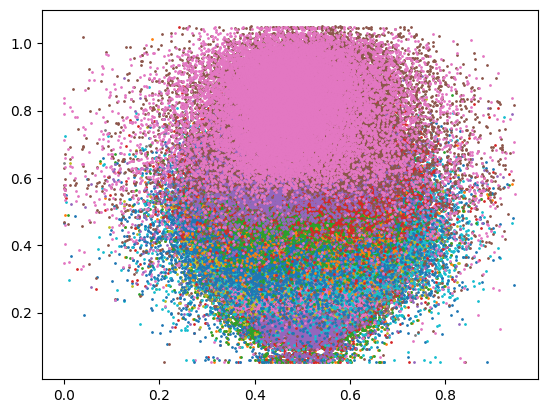

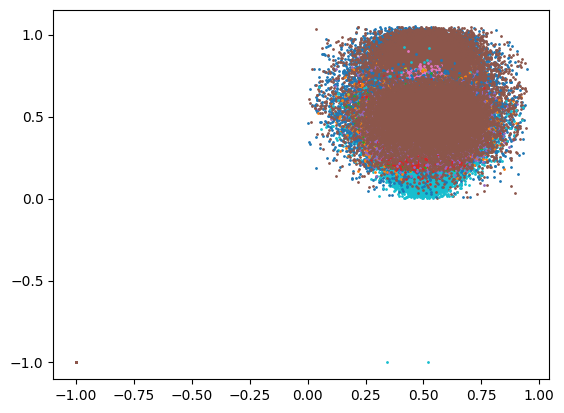

In [104]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

array[20554, 17, 2] n=698836 (5.3Mb) x∈[1.833e-05, 1.050] μ=0.493 σ=0.156


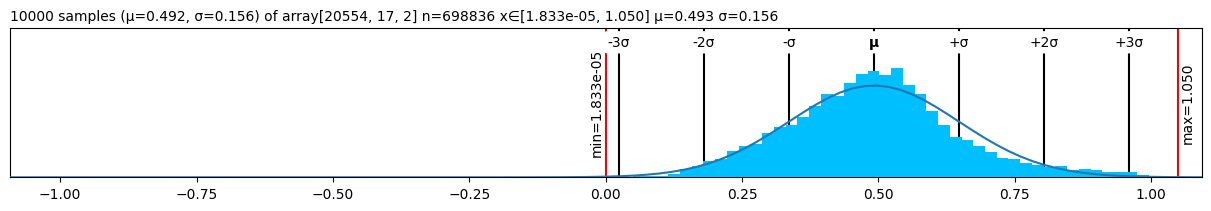

In [105]:
print(lo(X_normalized))
lo(X_normalized).plt

array[20554, 16, 2] n=657728 (5.0Mb) x∈[-1.000, 1.050] μ=0.399 σ=0.400


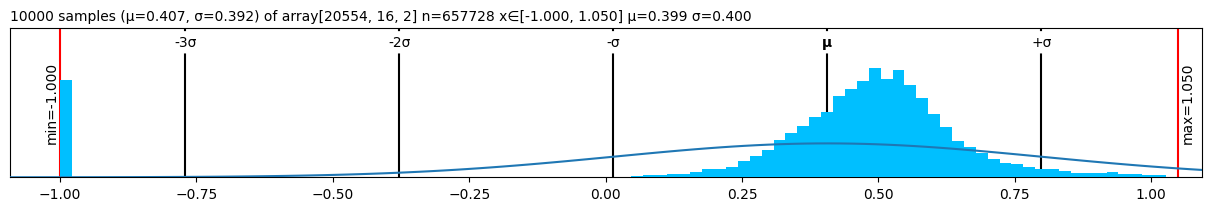

In [106]:
print(lo(y_normalized))
lo(y_normalized).plt

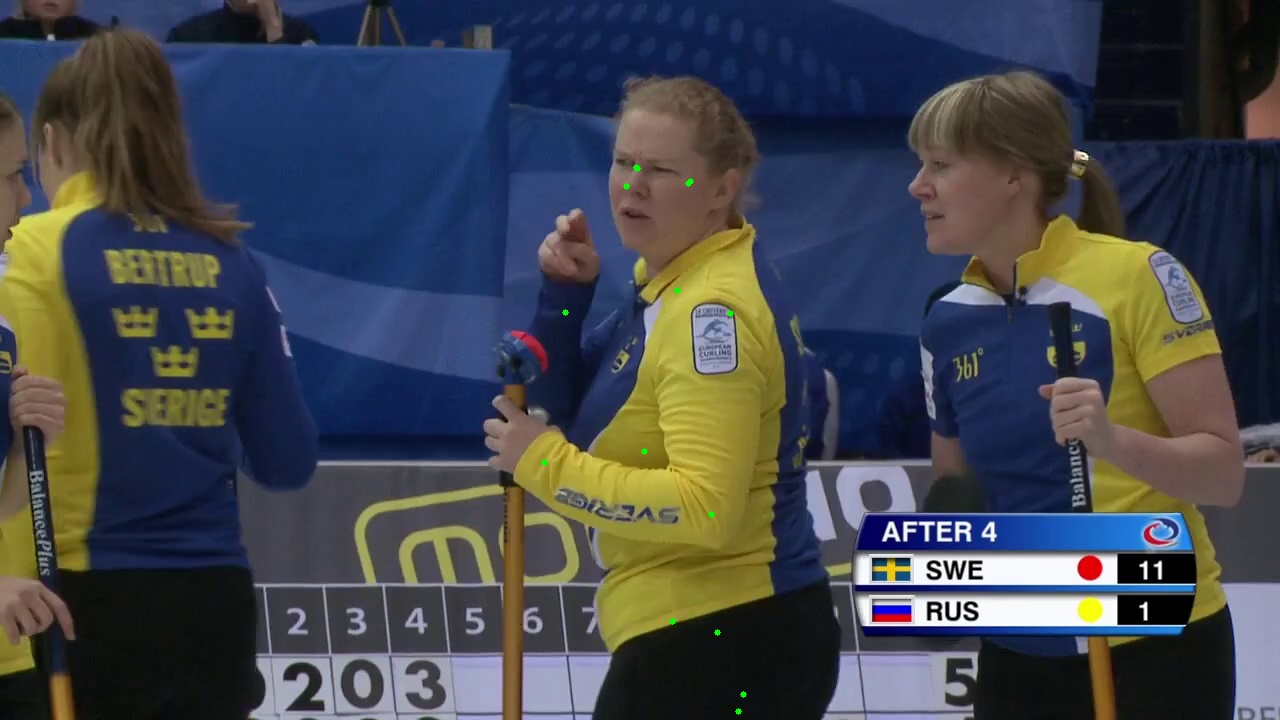

In [107]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'images/tm_results/image_test0.jpg', image)

  display(Image(filename=f'images/tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_pred_coco['annotations'][index2orig[index[0]]]['joints']
                 )

## Outlier images from coco prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


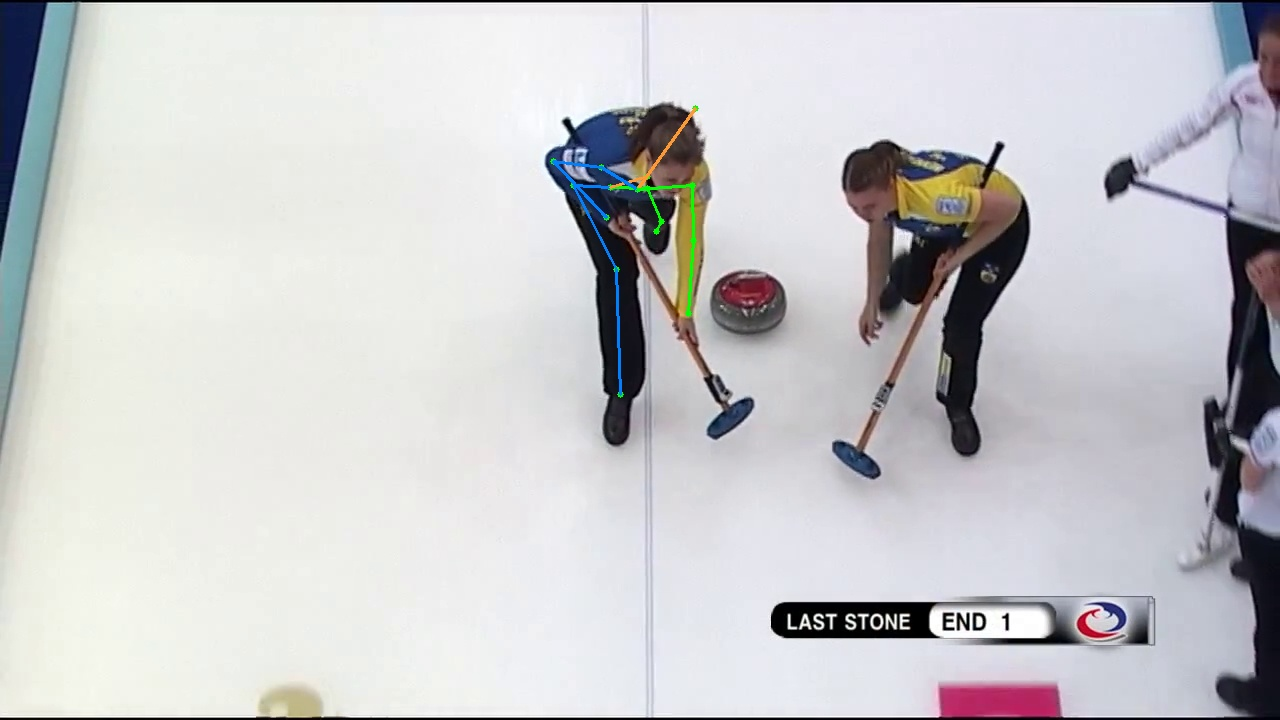

In [108]:
%load_ext autoreload
%autoreload 2

from visualize import visualize_with_keypoints, save_with_keypoints

visualize_with_keypoints(0, annot_truth, annot_truth[0]['joints'])

In [109]:
# N x 17 x 2
index = 0
count = 0
for row in range(y_normalized.shape[0]):
  
  for col in range(y_normalized.shape[1]):
    # Heads
      if y_normalized[row, col, 1] < 0 and y_normalized[row, col, 1] != -1:
        print("heree")
        save_with_keypoints(nth_image=row,
                           annot_truth=annot_truth, 
                           path = f'images/outliers/image{annot_truth[row]["image"]}',
                           keypoints=y[row],
                           skeleton=None,
                           bounding_box=(annot_truth[row]["center"],annot_truth[row]["scale"])
                           )
      index += 1  
# print("On the boundary: ", count)


# PCK Accuracy implementation

In [110]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    # only gt has -1 values
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        # Only use values that are defined
        _gt = gt
        _predict = predict

        mask = torch.all(gt[:, 8:10, 0] != -1, dim=1) 
        _predict = _predict[mask]
        _gt = _gt[mask]

        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask

        distances = torch.norm((_gt - _predict), dim=-1)
        head_length = torch.norm((_gt[:, 8] - _gt[:, 9]), dim=-1) * 0.5 * 0.6
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        correct_classified = distances <= head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
        return percentage.item()

    else:
        _gt = gt
        _predict = predict

        no_head_mask = np.all(gt[:, 8:10, 0] != -1, axis=1) 
        _predict = _predict[no_head_mask]
        _gt = _gt[no_head_mask]
        
        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask
        
        distances = np.linalg.norm((_gt - _predict), axis=-1)
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        head_length = np.linalg.norm((_gt[:, 8] - _gt[:, 9]), axis=-1) * 0.5 * 0.6
        correct_classified = distances <= head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / (total_keypoints)
    return percentage


calculatePCKh(y_normalized, y_normalized)

1.0

## Define baseline accuracy

In [111]:
# Fake X identity base/ Direct COCO->MPII
def handcraft(coco_x, mpii_y):
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_mpii_identity = np.ones_like(mpii_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_mpii_identity[:,mpii_key] = coco_x[:,coco_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
  # thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
  X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
  X_mpii_identity[:,8] = (X_mpii_identity[:,7]+coco_x[:,0])/2
  X_mpii_identity[:,9] = (coco_x[:, 1] + coco_x[:, 2] ) / 2
  return X_mpii_identity

X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculatePCKh(X_transformed_normalized, y_normalized))


0.810283471114807


## Split train, val, test

In [112]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  16443
Val instance:  4111
torch.Size([16443, 17, 2])
torch.Size([16443, 16, 2])
torch.Size([4111, 17, 2])
torch.Size([4111, 16, 2])


### Definition of augmentations

In [113]:
def random_shift(data , p=0.1, shift_constant=0.3):
  # N x 16 x 2
  if torch.rand(1).item() < p:
    data = copy.deepcopy(data)
    # random_batch_n = torch.randint(0, data.shape[0], (1, )).item()
    random_point = torch.randint(0, 16, (1, )).item()

    # random number between -0.15 to 0.15
    # to choose from gaussian distrubution
    random_shift_x = torch.randn(1).item() * shift_constant
    random_shift_y = torch.randn(1).item() * shift_constant

    data[:, random_point, 0] += random_shift_x
    data[:, random_point, 1] += random_shift_y
    return data
  
  return data

# swap_points = [(0,5), (1,4), (2,3), (10,15), (11,14), (12,13)]
def horizontal_flip(data_x, data_y, p=0.1):
  if torch.rand(1).item() < p:
    data_x = copy.deepcopy(data_x)
    data_y = copy.deepcopy(data_y)
    data_x[:,:,0] = 1 - data_x[:,:,0]
    data_y[:,:,0] = 1 - data_y[:,:,0]
    return data_x, data_y
  return data_x, data_y



In [147]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
 
        self.layers = nn.Sequential(nn.Flatten(),
                                     nn.Linear(input,512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, output)
                                     )
    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, x.shape[1] // 2  , 2)

def init_model(input, output):
    return TranslatorNN(input, output).to(device)

In [115]:
def train_model(model, train_loader, val_loader, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    mask = targets != -1
                    loss = criterion(outputs * mask, targets * mask)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for inputs, targets in train_loader:
            # Include data augmentation
            inputs = random_shift(inputs, p=0.2, shift_constant=0.1)   
            inputs,targets = horizontal_flip(inputs, targets, p=0.2)
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = targets != -1
            loss = criterion(outputs * mask, targets * mask)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                train_accuracy += (calculatePCKh(outputs, targets))

        epoch_loss = running_loss / len(train_dataset)
        train_accuracy = train_accuracy / (len(train_dataset) / train_loader.batch_size)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                mask = targets != -1
                loss = criterion(outputs * mask, targets * mask)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, TAccuracy: {train_accuracy * 100:.2f}%,  Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [116]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [1e-2]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_model_is_trained = False
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model(34, 32)
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model, train_loader, val_loader, lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
best_model_is_trained = True



1 [{'lr': 0.01, 'epoch': 200}]
Training for param: {'lr': 0.01, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=32, bias=True)
  )
)
Epoch [0/200], Val Loss: 0.465232
Epoch [1/200], Train Loss: 0.114180, TAccuracy: 15.15%,  Val Loss: 0.060137 Accuracy: 21.67%
Epoch [11/200], Train Loss: 0.039454, TAccuracy: 54.48%,  Val Loss: 0.029491 Accuracy: 58.75%
Epoch [21/200], Train Loss: 0.034945, TAccuracy: 66.26%,  Val Loss: 0.023599 Accura

In [117]:
print(best_params)
print(best_epoch)
print(best_accuracy)

{'lr': 0.01, 'epoch': 200}
193
0.8826149068473754


## Eval on test set

In [118]:
torch.save(best_model.state_dict(), 'models/translation_model/coco2mpii_vitpose_base_data.pth')

In [119]:
best_model

TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [120]:
def load_model_if_not_defined(best_model):
    if best_model != None:
      return best_model
    else:
        # Load your model here
        best_model = TranslatorNN(34, 32)
        best_model.load_state_dict(torch.load('./models/best_translation_model_with_augmentation1.pth', map_location=device))
        return best_model
best_model = load_model_if_not_defined(best_model)

In [121]:
best_model.to(device)

TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [122]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

X_test = list()
y_test = list()
test_box_scale = list()
test_box_center = list()

for i in range(len(annot_truth_val_set)):
  X_test.append(annot_pred_coco_val_set['annotations'][i]['joints'])
  y_test.append(annot_truth_val_set[i]['joints'])
  test_box_scale.append(annot_truth_val_set[i]['scale'])
  test_box_center.append(annot_truth_val_set[i]['center'])

X_test = np.array(X_test)
y_test = np.array(y_test)
test_box_scale = np.array(test_box_scale)
test_box_center = np.array(test_box_center)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)



X_test:  (2958, 17, 2)
y_test:  (2958, 16, 2)


/tmp/ipykernel_18628/228312879.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(np.clip(X_test_normalized[:, i, 0],-1,1),np.clip(X_test_normalized[:, i, 1],-1,1), s=1, vmin=-3, vmax=3)


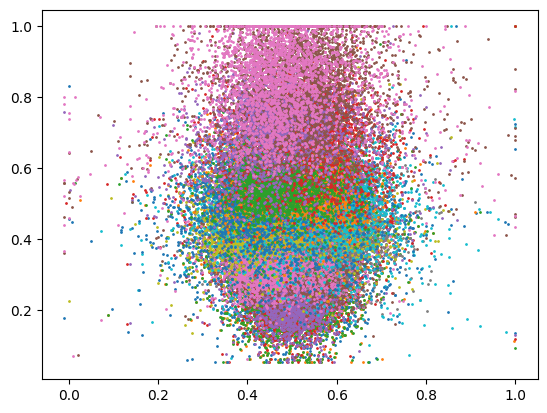

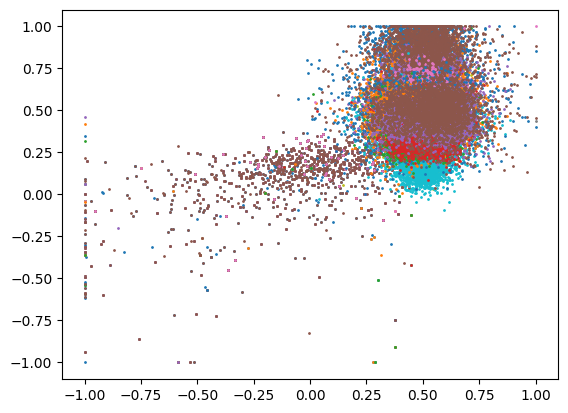

In [123]:
X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
y_test_normalized = normalize(y_test, test_box_center, test_box_scale, scale_px=200*1.25, mask = (y_test!=1))

for i in range(17):
  plt.scatter(np.clip(X_test_normalized[:, i, 0],-1,1),np.clip(X_test_normalized[:, i, 1],-1,1), s=1, vmin=-3, vmax=3)
plt.show()

for i in range(16):
  plt.scatter(np.clip(y_test_normalized[:, i, 0],-1,1),np.clip(y_test_normalized[:, i, 1],-1,1), s=1)
plt.show()

In [124]:
best_model.eval()

with torch.no_grad():
  X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
  X_test_feed_in = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_test_feed_in) 
print("Pred: ", prediction.shape)

Pred:  torch.Size([2958, 16, 2])


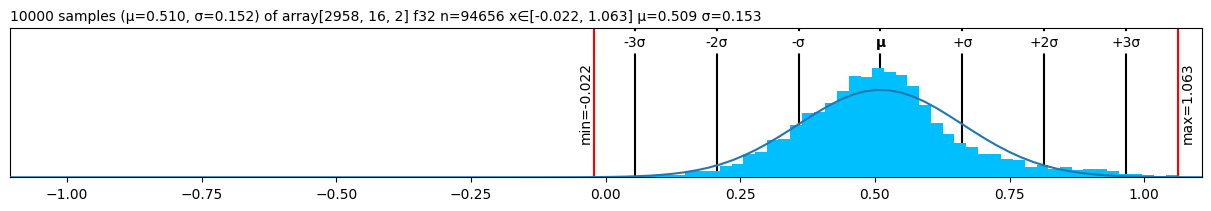

In [125]:
lo(np.array(prediction.cpu())).plt

In [126]:
gt_dict = scipy.io.loadmat(ROOT_FOLDER+'/data/MPII_COCO/annotations/mpii_gt_val.mat')

dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

pos_pred_src = unnormalize(prediction.cpu(), 
                           box_center=test_box_center,
                           box_scale=test_box_scale,
                           )
pos_pred_src = np.transpose(pos_pred_src.cpu(), [1, 2, 0])

head = np.where(dataset_joints == 'head')[1][0]
lsho = np.where(dataset_joints == 'lsho')[1][0]
lelb = np.where(dataset_joints == 'lelb')[1][0]
lwri = np.where(dataset_joints == 'lwri')[1][0]
lhip = np.where(dataset_joints == 'lhip')[1][0]
lkne = np.where(dataset_joints == 'lkne')[1][0]
lank = np.where(dataset_joints == 'lank')[1][0]

rsho = np.where(dataset_joints == 'rsho')[1][0]
relb = np.where(dataset_joints == 'relb')[1][0]
rwri = np.where(dataset_joints == 'rwri')[1][0]
rkne = np.where(dataset_joints == 'rkne')[1][0]
rank = np.where(dataset_joints == 'rank')[1][0]
rhip = np.where(dataset_joints == 'rhip')[1][0]

SC_BIAS = 0.6
threshold = 0.5

jnt_visible = 1 - jnt_missing
uv_error = pos_pred_src - pos_gt_src

uv_err = np.linalg.norm(uv_error, axis=1)
headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
headsizes = np.linalg.norm(headsizes, axis=0)
headsizes *= SC_BIAS
scale = headsizes * np.ones((len(uv_err), 1), dtype=np.float32)
scaled_uv_err = uv_err / scale
scaled_uv_err = scaled_uv_err * jnt_visible
jnt_count = np.sum(jnt_visible, axis=1)
less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
PCKh = 100. * np.sum(less_than_threshold, axis=1) / jnt_count

# save
rng = np.arange(0, 0.5 + 0.01, 0.01)
pckAll = np.zeros((len(rng), 16), dtype=np.float32)

for r, threshold in enumerate(rng):
    less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
    pckAll[r, :] = 100. * np.sum(
        less_than_threshold, axis=1) / jnt_count

PCKh = np.ma.array(PCKh, mask=False)
print("PCKh Thorax: ", PCKh[6])
print("PCKh Pelvis: ", PCKh[7])
PCKh.mask[6:8] = True

jnt_count = np.ma.array(jnt_count, mask=False)
jnt_count.mask[6:8] = True
jnt_ratio = jnt_count / np.sum(jnt_count).astype(np.float64)

name_value = [('Head', PCKh[head]),
              ('Shoulder', 0.5 * (PCKh[lsho] + PCKh[rsho])),
              ('Elbow', 0.5 * (PCKh[lelb] + PCKh[relb])),
              ('Wrist', 0.5 * (PCKh[lwri] + PCKh[rwri])),
              ('Hip', 0.5 * (PCKh[lhip] + PCKh[rhip])),
              ('Knee', 0.5 * (PCKh[lkne] + PCKh[rkne])),
              ('Ankle', 0.5 * (PCKh[lank] + PCKh[rank])),
              ('Thorax', PCKh[7]),
              ('Pelvis', PCKh[6]),
              ('Upper neck', PCKh[8]),
              ('PCKh', np.sum(PCKh * jnt_ratio)),
              ('PCKh@0.1', np.sum(pckAll[10, :] * jnt_ratio))]
for val in name_value:
    print(f'{val[0]}: {val[1]:.2f}%')




PCKh Thorax:  91.93884642112579
PCKh Pelvis:  97.74897680763983
Head: 93.25%
Shoulder: 95.09%
Elbow: 89.33%
Wrist: 84.56%
Hip: 87.97%
Knee: 85.83%
Ankle: 82.10%
Thorax: --%
Pelvis: --%
Upper neck: 96.52%
PCKh: 88.88%
PCKh@0.1: 26.93%


/tmp/ipykernel_18628/3963776908.py:77: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f'{val[0]}: {val[1]:.2f}%')


In [127]:
pos_gt_src.shape

(16, 2, 2958)

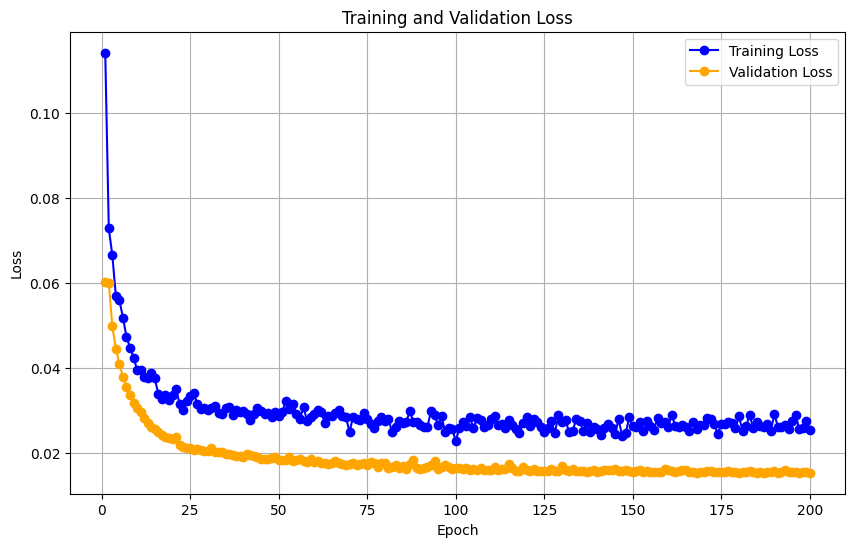

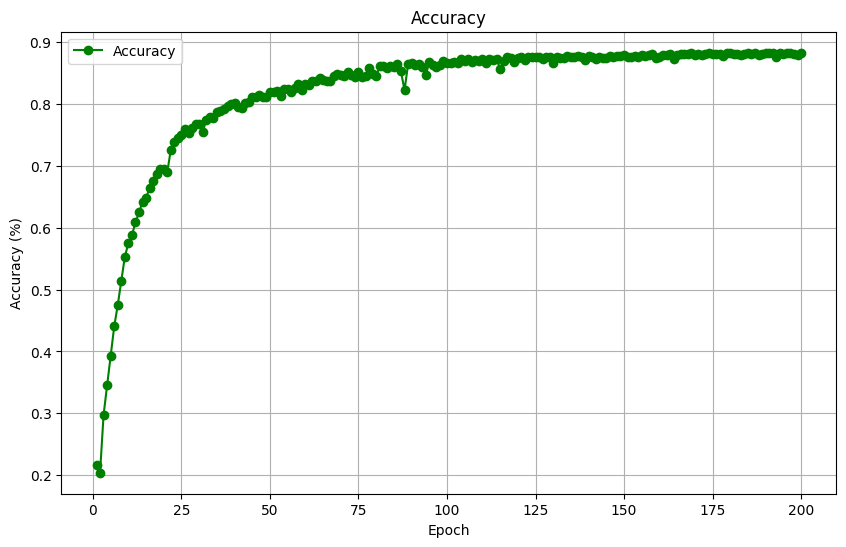

In [128]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Display some images from translation model

In [129]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

In [130]:
# dataset_info['skeleton_info']
kps_name2index = {dataset_info['keypoint_info'][key]['name']:key for key in dataset_info['keypoint_info'] }
print(kps_name2index)


{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}


## Saving some translated images for future references
- green is the prediction and red is the gt

In [131]:
from visualize import save_with_multiple_keypoints
# N x 17 x 2
y_preds_orig = unnormalize(prediction.cpu(), test_box_center, test_box_scale)

index = 0
count = 0


random_numbers = np.random.randint(0, 2958, size=25)

for rand_ind in random_numbers:
   save_with_multiple_keypoints(nth_image=rand_ind,
                           annot_truth=annot_truth_val_set, 
                           path = f'images/coco2mpii/image{annot_truth_val_set[rand_ind]["image"]}',
                           # Green COCO
                           keypoints=X_test[rand_ind],
                           skeleton=None,
                           bounding_box=(annot_truth_val_set[rand_ind]["center"],annot_truth_val_set[rand_ind]["scale"]),
                           # Green
                           keypoints1=y_preds_orig[rand_ind],
                           # Red
                           keypoints2=annot_truth_val_set[rand_ind]["joints"],


                           label1="COCO Pred",
                           label2="COCO->MPII and GT"
                           )



031416741.jpg
bbleft: (837, 100)
bbright: (1248, 511)
004466003.jpg
bbleft: (339, 58)
bbright: (926, 645)
069747146.jpg
bbleft: (11, 172)
bbright: (512, 673)
095830936.jpg
bbleft: (692, -28)
bbright: (1447, 726)
025669855.jpg
bbleft: (-537, -454)
bbright: (1489, 1572)
094898067.jpg
bbleft: (444, -88)
bbright: (1365, 832)
096776147.jpg
bbleft: (366, 123)
bbright: (1265, 1022)
058133922.jpg
bbleft: (233, 27)
bbright: (1020, 814)
065329024.jpg
bbleft: (-678, -479)
bbright: (1282, 1481)
087897890.jpg
bbleft: (324, 163)
bbright: (697, 536)
021494038.jpg
bbleft: (166, -68)
bbright: (539, 304)
097730791.jpg
bbleft: (49, -56)
bbright: (616, 510)
051633982.jpg
bbleft: (863, 338)
bbright: (1196, 671)
043042741.jpg
bbleft: (363, 216)
bbright: (722, 575)
043243717.jpg
bbleft: (10, -13)
bbright: (597, 573)
075513362.jpg
bbleft: (-103, -45)
bbright: (1009, 1067)
001289747.jpg
bbleft: (4, -22)
bbright: (691, 664)
068658093.jpg
bbleft: (-334, -68)
bbright: (856, 1122)
081686048.jpg
bbleft: (287, 36)
b

# Save the result

In [132]:
# gt = 

ROOT_FOLDER = "/datagrid/personal/baljibil"

with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base/IMG-mpii_train-Rep-coco.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth_val_set = json.load(f)

with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base/IMG-mpii_val-Rep-coco.json', 'r') as f:
    annot_pred_coco_val_set = json.load(f)



In [133]:
X = []
y = []
box_scale = []
box_center = []
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)

In [134]:
best_model.eval()

with torch.no_grad():
  X_train_normalized = normalize(X, box_center, box_scale)
  X_trian_normalized_tens = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_trian_normalized_tens).cpu().numpy()
  prediction = unnormalize(prediction, box_center, box_scale)
print("Pred: ", prediction.shape)

Pred:  (22246, 16, 2)


### Write all the results t_model(X_coco) -> mpii to json.

In [135]:
res = []
for i in range(len(prediction)):
  joint = prediction[i]
  pred_item = copy.deepcopy(annot_truth[i])
  pred_item['joints'] = joint.tolist()
  res.append(pred_item)
# json.dump()
res_path = 'data/trans_model_coco2mpii/result.json'
with open(res_path, 'w') as f:
  json.dump(res, f,  indent=4)


# MPII -> COCO with own data that comes from translational model
- Use MPII = Transmodel(COCO)
- Then MPII is the new X
- With GT or Y as COCO

In [136]:
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/trans_model_coco2mpii/result.json', 'r') as f:
    annot_pred_mpii_train = json.load(f)
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base/IMG-mpii_train-Rep-coco.json', 'r') as f:
    # Technically this also is a predication that currently uses Vitpose base. But for the sake of speed
    # i'm iterating on this data.
    annot_gt_train = json.load(f)

In [137]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_mpii_train[i]['joints'])
  y.append(annot_gt_train['annotations'][i]['joints'])
  box_scale.append(annot_pred_mpii_train[i]['scale'])
  box_center.append(annot_pred_mpii_train[i]['center'])
X = np.array(X)
# X_score = X[:,:,-1]
# X = X[:,:,:-1]

y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (22246, 16, 2)
y shape: (22246, 17, 2)
box scale: (22246,)
box center: (22246, 2)


In [138]:
X_normalized = normalize(X, box_center, box_scale)
y_normalized = normalize(y, box_center, box_scale)

### Define the baseline

In [139]:
def handcraft(mpii_x, coco_y):
  """
  Connecting mergeable points to the correct index
  """
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_coco = np.ones_like(coco_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_coco[:,coco_key] = mpii_x[:,mpii_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  X_coco[:, 0] = (mpii_x[:,8] + mpii_x[:,9])/2
  return X_coco
# MPII->COCO
X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculatePCKh(X_transformed_normalized, y_normalized))

0.7409924322151769


In [140]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  17796
Val instance:  4450
torch.Size([17796, 16, 2])
torch.Size([17796, 17, 2])
torch.Size([4450, 16, 2])
torch.Size([4450, 17, 2])


In [148]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [1e-2]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model(32, 34)
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model, train_loader, val_loader, lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.01, 'epoch': 200}]
Training for param: {'lr': 0.01, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=34, bias=True)
  )
)
Epoch [0/200], Val Loss: 0.494701
Epoch [1/200], Train Loss: 0.108794, TAccuracy: 22.39%,  Val Loss: 0.068987 Accuracy: 29.28%
Epoch [11/200], Train Loss: 0.023379, TAccuracy: 76.85%,  Val Loss: 0.022656 Accuracy: 77.52%
Epoch [21/200], Train Loss: 0.015717, TAccuracy: 87.29%,  Val Loss: 0.014579 Accura

In [149]:
best_model.eval()

with torch.no_grad():
  X_train_normalized = normalize(X, box_center, box_scale)
  X_train_normalized_tens = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_train_normalized_tens).cpu().numpy()
  prediction = unnormalize(prediction, box_center, box_scale)
print("Pred: ", prediction.shape)

Pred:  (22246, 17, 2)


In [164]:
X.shape

(22246, 16, 2)

In [163]:
np.array(annot_gt_train["annotations"][0]['joints']).shape

(17, 2)

In [166]:
from visualize import save_with_multiple_keypoints
# N x 16 x 2

index = 0
count = 0


random_numbers = np.random.randint(0, 2958, size=25)

for rand_ind in random_numbers:
   save_with_multiple_keypoints(nth_image=rand_ind,
                           annot_truth=annot_pred_mpii_train, 
                           path = f'images/mpii2coco/image{annot_pred_mpii_train[rand_ind]["image"]}',
                           # Green COCO
                           keypoints=annot_pred_mpii_train[rand_ind]["joints"],
                           skeleton=None,
                           bounding_box=(annot_gt_train["annotations"][rand_ind]["center"],annot_gt_train["annotations"][rand_ind]["scale"]),
                           # Green
                           keypoints1=prediction[rand_ind],
                           # Red

                           # label1="COCO Pred",
                           # label2="COCO->MPII and GT"
                           )



003892996.jpg
bbleft: (-19, 67)
bbright: (489, 576)
043030589.jpg
bbleft: (404, 372)
bbright: (671, 639)
055417800.jpg
bbleft: (439, 163)
bbright: (698, 422)
040873417.jpg
bbleft: (736, 98)
bbright: (1393, 755)
024682387.jpg
bbleft: (70, -401)
bbright: (1479, 1007)
075271664.jpg
bbleft: (332, 70)
bbright: (631, 369)
044391945.jpg
bbleft: (-53, -537)
bbright: (2697, 2213)
086791829.jpg
bbleft: (-104, -201)
bbright: (630, 533)
040710649.jpg
bbleft: (32, 122)
bbright: (707, 797)
021070496.jpg
bbleft: (289, -246)
bbright: (2286, 1750)
040754303.jpg
bbleft: (986, 222)
bbright: (1671, 907)
023763754.jpg
bbleft: (-228, 157)
bbright: (340, 726)
068261722.jpg
bbleft: (224, -91)
bbright: (921, 605)
084332617.jpg
bbleft: (99, 37)
bbright: (1160, 1098)
077387966.jpg
bbleft: (850, 160)
bbright: (1271, 581)
047380983.jpg
bbleft: (-183, -76)
bbright: (545, 652)
050942213.jpg
bbleft: (333, -7)
bbright: (746, 405)
002581191.jpg
bbleft: (544, 13)
bbright: (1215, 684)
029238311.jpg
bbleft: (540, -211)
bb

In [167]:
prediction[:5, :5]

array([[[679.6921  , 185.85155 ],
        [680.606   , 177.17699 ],
        [681.2009  , 176.52708 ],
        [669.1549  , 153.32448 ],
        [669.6696  , 153.22008 ]],

       [[865.7031  , 213.47842 ],
        [864.1608  , 206.40121 ],
        [864.551   , 206.12042 ],
        [880.639   , 188.47662 ],
        [880.92993 , 188.48318 ]],

       [[636.1059  , 192.32512 ],
        [645.3308  , 172.10423 ],
        [646.1136  , 171.10155 ],
        [689.8106  , 178.21873 ],
        [689.86926 , 178.23216 ]],

       [[941.69977 , 195.27707 ],
        [945.3218  , 173.24539 ],
        [946.0862  , 172.1979  ],
        [995.9857  , 174.2507  ],
        [995.9812  , 174.18283 ]],

       [[ 80.87569 , 149.80537 ],
        [ 85.010574, 129.167   ],
        [ 85.386734, 128.56636 ],
        [112.37453 , 132.60536 ],
        [112.109695, 132.63112 ]]], dtype=float32)